In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

# Looping through every table in the datasets folder...
for table_name in os.listdir('../input/sentiments-dataset'):
    table_path = f'../input/sentiments-dataset/{table_name}'
    
    # Opening file in read-only mode
    table_file = open(table_path, 'r')
    
    html = BeautifulSoup(open(table_path, 'r'))
    
    # Finding 'news-table' loading it into 'html_table'
    html_table = html.find(id='news-table')
    
    # Adding to dictionary
    html_tables[table_name] = html_table   

print('ok!')

ok!


In [2]:
# Reading headlines of a single day 
tsla = html_tables['tsla_22sep.html']

# Getting all the rows tagged with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# Looping through each row
for i, table_row in enumerate(tsla_tr):
    # Reading the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    
    # Reading the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    
    # Printing the count
    print(f'{i}:')
    
    #Printing stored data
    print(link_text)
    print(data_text)
    
    # To display just 3 headlines
    if i == 2:
        break
    

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  


In [3]:
# List to contain the parsed news
parsed_news = []

# Looping through the news
for file_name, news_table in html_tables.items():
    # Iterating through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        
        # Reading the tr tag's text into 'text'
        text = x.get_text()

        # Splitting the td tag's text into a list 
        date_scrape = x.td.text.split()
        headline = x.a.text

        # If the length of 'date_scrape' is 1, the only element present is 'time'
        # Else, it contains 'data' and 'time' as first and second elements respectively
        
        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        
        # Extracting ticker from file name(everything till first '_') 
        ticker = file_name.split('_')[0]
        
        # Appending ticker, date, time and headline to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])

print(parsed_news[:10])


[['fb', 'Jan-04-19', '06:22PM', 'Facebook, Apple, Netflix, Amazon and Alphabet Power Friday Gains'], ['fb', 'Jan-04-19', '05:15PM', 'Earnings Reports for the Week of Jan. 7-11 (BBBY, KBH)'], ['fb', 'Jan-04-19', '04:55PM', 'COLUMN-Commentary: 2019 will be the year of more state control'], ['fb', 'Jan-04-19', '04:53PM', '3 Tech Trends to Watch in 2019'], ['fb', 'Jan-04-19', '04:30PM', "Will Denver's tech growth continue in 2019?"], ['fb', 'Jan-04-19', '02:46PM', 'Facebook to Prioritize Video in 2019'], ['fb', 'Jan-04-19', '01:52PM', 'ScotteVest CEO: How a Facebook Passion Project Evolved into a New Business'], ['fb', 'Jan-04-19', '01:47PM', 'Millennials Load Up on Battered Apple, Facebook, GE'], ['fb', 'Jan-04-19', '01:00PM', 'FAANGs See a Weak Start to 2019: More Pain Ahead for ETFs?'], ['fb', 'Jan-04-19', '12:18PM', 'U[PDATE: Netflix shares soar 9% as Goldman adds stock to its Conviction List']]


In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

# Instantiating with existing lexicon
vader = SentimentIntensityAnalyzer()

# Updating the lexicon
vader.lexicon.update(new_words)

print('ok!')

ok!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
columns = ['ticker', 'date', 'time', 'headline']

# Converting the list into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)

# polarity scores after iterating through headlines
scores = scored_news['headline'].apply(vader.polarity_scores)

# Converting the list of dictionaries into a DataFrame
scores_df = pd.DataFrame.from_records(scores)

# Joining the DataFrames
scored_news = scored_news.join(scores_df)

# Converting the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
print(scored_news.head())

  ticker        date     time  \
0     fb  2019-01-04  06:22PM   
1     fb  2019-01-04  05:15PM   
2     fb  2019-01-04  04:55PM   
3     fb  2019-01-04  04:53PM   
4     fb  2019-01-04  04:30PM   

                                            headline  neg    neu    pos  \
0  Facebook, Apple, Netflix, Amazon and Alphabet ...  0.0  0.631  0.369   
1  Earnings Reports for the Week of Jan. 7-11 (BB...  0.0  1.000  0.000   
2  COLUMN-Commentary: 2019 will be the year of mo...  0.0  1.000  0.000   
3                     3 Tech Trends to Watch in 2019  0.0  1.000  0.000   
4        Will Denver's tech growth continue in 2019?  0.0  0.698  0.302   

   compound  
0    0.4767  
1    0.0000  
2    0.0000  
3    0.0000  
4    0.3818  


<AxesSubplot:xlabel='date'>

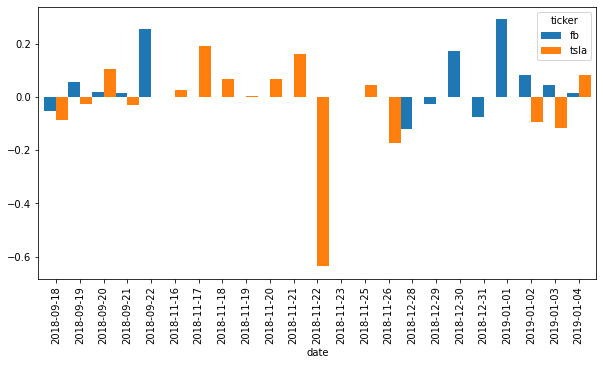

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#calculating mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()

# Unstack the ticker column
mean_c = mean_c.unstack('ticker')
mean_c = mean_c.xs('compound', axis='columns')

mean_c.plot(kind='bar', figsize=(10,5), width=1)

In [7]:
num_news_before = scored_news['headline'].count()

# Dropping duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker','headline'])

num_news_after = scored_news_clean['headline'].count()
                                                        
# Print before and after counts 
print(f"Before we had {num_news_before} headlines, now we have {num_news_after}")

Before we had 500 headlines, now we have 476


In [8]:
scored_news_clean.set_index(["ticker", "date"]).xs("fb")

,time,headline,neg,neu,pos,compound
date,,,,,,
2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.000,0.631,0.369,0.4767
2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.000,1.000,0.000,0.0000
2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.000,1.000,0.000,0.0000
2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.000,1.000,0.000,0.0000
2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.000,0.698,0.302,0.3818
...,...,...,...,...,...,...
2018-09-18,01:40PM,The Tesla of China & the Facebook-Macy's Conne...,0.000,0.708,0.292,0.5106
2018-09-18,01:24PM,"Facebook Can't Settle One Ad Bias Claim, Gets ...",0.123,0.877,0.000,-0.1027
2018-09-18,01:24PM,"Facebook Can't Settle an Ad Bias Claim, Draws ...",0.310,0.690,0.000,-0.3818


In [9]:
scored_news_clean.set_index(["ticker", "date"]).xs("fb").index

Index([2019-01-04, 2019-01-04, 2019-01-04, 2019-01-04, 2019-01-04, 2019-01-04,
       2019-01-04, 2019-01-04, 2019-01-04, 2019-01-04,
       ...
       2018-09-18, 2018-09-18, 2018-09-18, 2018-09-18, 2018-09-18, 2018-09-18,
       2018-09-18, 2018-09-18, 2018-09-18, 2018-09-18],
      dtype='object', name='date', length=190)

In [10]:
scored_news_clean.loc[:, "date"] = pd.to_datetime(scored_news.loc[:, "date"])

single_day = scored_news_clean.set_index(['ticker', 'date'])

# Cross-section the fb row
single_day = single_day.xs('fb')

# Selecting the 3rd of January of 2019
single_day = single_day['2019-01-3']

# Converting the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

single_day = single_day.set_index('time')

# Sorting
single_day = single_day.sort_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:xlabel='time'>

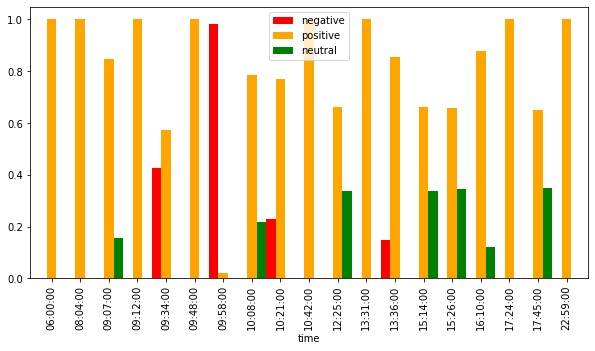

In [11]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]

# Dropping some columns
plot_day = single_day.drop(['headline', 'compound'], axis=1)

# Changing the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']

plot_day.plot(kind='bar', color=COLORS, figsize=(10,5), width=1)